In [5]:
import sys
sys.path.insert(0, '../classes')

from Model import Model as Model

import pickle

%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from importlib import reload

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
params = {
 'grid.color': '.9',
 'axes.edgecolor': '.5',
 'text.color': '.3',
 'xtick.color': '.5',
 'xtick.direction': 'out',
 'xtick.major.size': 6.0,
 'xtick.minor.size': 3.0,
 'ytick.color': '.5',
 'ytick.direction': 'out',
 'ytick.major.size': 6.0,
 'ytick.minor.size': 3.0    
}
sns.set_style("whitegrid", params)

In [50]:
"""
 FEDFUNDS     : Effective Fed Funds Rate, percent.
 GDP          : Real GDP, 3 decimals, billions of Chained 2000 Dollars.
 INDPRO       : Industrial Production Index
 CPIAUCSL     : Consumer Price Index for All Urban Consumers: All Items
 UNRATE       : Civilian Unemployment Rate
 PAYEMS       : All Employees: Total Nonfarm Payrolls
"""

data = pd.read_csv('quarterly.csv', index_col = 'DATE')
data.head()

,GDPC1,CPIAUCSL,FEDFUNDS,INDPRO,PAYEMS,UNRATE
DATE,,,,,,
1959-01-01,2976.6,29.01,2.48,22.7253,52480.0,6.0
1959-04-01,3049.0,28.98,2.96,24.0048,53320.0,5.2
1959-07-01,3043.1,29.15,3.47,23.8101,53803.0,5.1
1959-10-01,3055.1,29.35,3.98,22.8087,53359.0,5.7
1960-01-01,3123.2,29.37,3.99,25.0061,54274.0,5.2


In [51]:
import scipy.io as sio

factors_data = sio.loadmat('factors.mat')

# process the factors: raw

factors_q = pd.DataFrame(factors_data['quarterly'])

# drop the last period (as done with the data)
factors_q = factors_q[:-1]

# drop every col that has missings after the beginning
factors_q = factors_q.ix[:, factors_q[5:].isnull().sum(axis=0)==0]


factors_q.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]


,0,1,2,3,4,5,6,7,8,9,...,179,180,181,186,195,197,198,199,200,201
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.859993,NaN,NaN,NaN,NaN,NaN
1,0.014227,0.005304,0.022827,0.003951,0.001112,0.062618,0.018332,0.012693,0.013744,0.028256,...,0.003183,0.006014,0.040836,-0.001972,7.463962,-0.041741,-0.013931,-0.002364,0.016019,-0.004836
2,-0.011699,0.000418,0.005026,0.002466,-0.003265,-0.079012,-0.001480,0.015249,0.011848,-0.024915,...,-0.002238,0.000258,0.034865,0.004471,7.134122,-0.001249,0.001657,0.005996,-0.010793,-0.013843
3,-0.005819,-0.008827,-0.062926,0.001149,-0.000902,0.019813,-0.023673,-0.018783,-0.017363,-0.034727,...,-0.002049,0.000497,-0.008452,0.001178,7.536827,0.014089,0.001296,0.007746,0.027083,-0.018261
4,0.012316,-0.000460,0.017535,-0.001931,-0.004577,0.083615,0.020861,0.017329,0.019564,0.024249,...,0.006901,0.010527,-0.037736,0.001021,13.838466,0.026844,0.008344,-0.008004,-0.027850,-0.006025


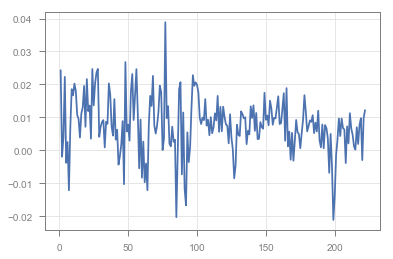

In [52]:
df_raw = data.reset_index(drop = True)
df_raw.columns = ['GDP', 'CPI', 'FF', 'IP', 'emp', 'unemp']

# put the interest variable, GDP, in the format we want to predict: the percentage growth from last period
df = df_raw.copy()
df['GDP'] = df_raw[['GDP']].pct_change()
df = df.iloc[1:]

plt.plot(df['GDP'])

In [53]:
def splitTimeData(df, ratio):
    rows = len(df.index)
    trainRows = int(rows * (1 - ratio))
    testRows = rows - trainRows
    
    train = df.ix[0:trainRows-1]
    test = df #df.ix[trainRows:rows+1]
    start = trainRows
    
    return train, test, start

df_train, df_test, start = splitTimeData(df, 0.18)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


In [54]:
'''
standard transformations
'''
from Transform import Transform as Transform

cols = ['IP', 'GDP', 'emp', 'CPI', 'FF']

# not FF, GDP or unemp
t1 = Transform('log', ['IP', 'emp', 'CPI'])

o = {
    'diffs': {
        'IP': 1,
        'GDP': 0,
        'emp': 1,
        'CPI': 2,
        'FF': 1
    }
}


t2 = Transform('diff', cols, o)
t3 = Transform('standardize', cols)
# t3 = Transform('normalize', cols)

transfs =  [t1, t2, t3]

In [55]:
'''
standard scorefuns
'''

def RMSE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    RMSE = np.sqrt(np.mean(np.square(errors)))[0]
    return RMSE

def MAE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    MAE = np.mean(np.absolute(errors))[0]
    return MAE

In [65]:
TRAIN_OFFSET = 160
TEST_OFFSET = df_train.last_valid_index() + 1

In [57]:
results = {}

In [349]:
df_train

,GDP,CPI,FF,IP,emp,UNEMPY
1,0.025631,28.98,2.96,24.0048,53320.0,5.2
2,0.001908,29.15,3.47,23.8101,53803.0,5.1
3,0.007807,29.35,3.98,22.8087,53359.0,5.7
4,0.026450,29.37,3.99,25.0061,54274.0,5.2
5,-0.001104,29.54,3.92,24.3664,54812.0,5.2
6,0.006081,29.55,3.23,23.9492,54304.0,5.5
7,-0.008974,29.75,2.47,23.6432,54144.0,6.1
8,0.008871,29.84,1.45,22.8922,53683.0,6.6
9,0.021066,29.81,1.49,23.4763,53626.0,7.0
10,0.019376,29.92,1.17,24.4498,54123.0,7.0


# baseline

In [1513]:
# train

import Model
reload(Model)
Model = 1
from Model import Model as Model


import LastPeriod
reload(LastPeriod)
LastPeriod = 1
from LastPeriod import LastPeriod as LastPeriod



cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = LastPeriod.gen_X(X, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = LastPeriod.gen_y(y, start)
    return y

model = LastPeriod()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'direct')
[ret[h][0] for h in window]

step: 160
step: 170
step: 180
step: 160
step: 170
step: 180
step: 160
step: 170
step: 180


[0.0079724071595529619, 0.0073047750881164199, 0.0087981766758104818]

In [1811]:
import LastPeriod
reload(LastPeriod)
LastPeriod = 1
from LastPeriod import LastPeriod as LastPeriod


import lag
reload(lag)
lag = 1
from lag import lag

import Model
reload(Model)
Model = 1
from Model import Model

# test
cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = LastPeriod.gen_X(X, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = LastPeriod.gen_y(y, start)
    return y

model = LastPeriod()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_base = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'direct')
results['BASE'] = ret_base
# score, predictions, test_errors, train_scores = ret[1]
# score, train_scores[-1]

[ret_base[h][0] for h in window]


# score, predictions, test_errors, train_scores = m.expanding_window(X_test, y_test, TEST_OFFSET)
# preds['LastPeriod'] = predictions
# score, train_scores[-1]

step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220


[0.0072212569384425499, 0.0093430396086289381, 0.010466315408835523]

In [231]:
MAE(preds['LastPeriod'], y_test)

90.544222414024702

# Uni

## AR

In [ ]:
from var_model import VAR as VAR

cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


def tune(p):
    lags = p

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = VAR()

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
    print(p)
    return p, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res = [tune(p) for p in range(1, 16)]

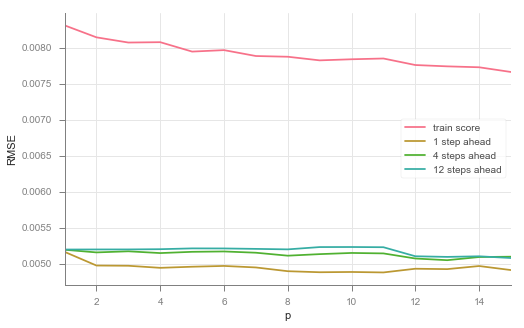

In [2059]:
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

# plt.savefig('destination_path.eps', format='eps', dpi=200)

## MA

In [1821]:
# train
from ARMA import ARMA as ARMA
from var_model import VAR as VAR

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

def tune(q):
    model = ARMA(0, q)

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic-ar')
    print(q)
    return q, ret[1][3][-1], ret[1][0], ret[4][0], ret[12][0]

res = [tune(p) for p in range(1, 11)]


step: 140
step: 150
step: 160


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 170
step: 180
step: 140
step: 150
step: 160


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 170
step: 180
step: 140
step: 150
step: 160
step: 170


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 180
1
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
2
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
3
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
4
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
5
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
6
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
7
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 

In [1824]:
df

,0,1,2,3,4
0,1,0.008392,0.005214,0.005198,0.005198
1,2,0.008206,0.004987,0.005198,0.005201
2,3,0.008202,0.004997,0.005198,0.005201
3,4,0.008150,0.004928,0.005196,0.005204
4,5,0.008129,0.004897,0.005197,0.005202
5,6,0.008101,0.004831,0.005196,0.005204
6,7,0.008050,0.004921,0.005198,0.005200
7,8,0.007994,0.004885,0.005198,0.005195
8,9,0.007994,0.004902,0.005199,0.005195
9,10,0.007994,0.004912,0.005200,0.005196


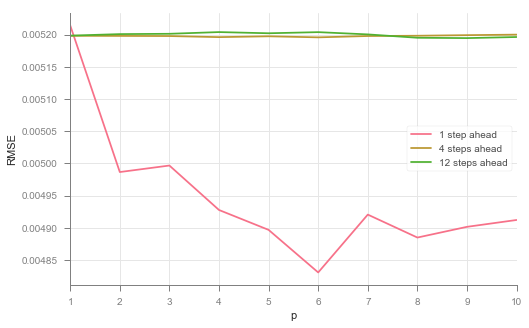

In [1825]:
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

# plt.savefig('destination_path.eps', format='eps', dpi=200)

## MSREG (AR)

In [597]:
# train
from MSReg import MSReg

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 3


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)

m = Model(model, transfs, gen_x, gen_y, RMSE)

score, predictions, test_errors, train_scores = m.expanding_window(X_train, y_train, TRAIN_OFFSET)
score, train_scores[-1]

step: 160
step: 170
step: 180
160


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:391: RuntimeWarning: invalid value encountered in true_divide
  predicted_joint_probabilities[..., t+1])


(0.00613129526271077, 0.015074549913987724)

In [1114]:
import Model
reload(Model)
Model = 1
from Model import Model as Model

import splitVAR
reload(splitVAR)
splitVAR = 1
from splitVAR import splitVAR as splitVAR


cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = model = splitVAR(2, proba = False, WLS=False, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)


m = Model(model, transfs, gen_x, gen_y, RMSE)

score, predictions, test_errors, train_scores = m.expanding_window(X_train, y_train, TRAIN_OFFSET)
score, train_scores[-1]

step: 160


KeyboardInterrupt: 

In [1145]:
import splitVAR
reload(splitVAR)
splitVAR = 1
from splitVAR import splitVAR as splitVAR

import Model
reload(Model)
Model = 1
from Model import Model as Model


cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = model = splitVAR(3, proba = True, WLS=True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_splitAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['splitAR'] = ret_splitAR
[ret_splitAR[h][0] for h in window]
# score, predictions, test_errors, train_scores = m.expanding_window(X_test, y_test, TEST_OFFSET)
# preds['SPLITVAR-AR'] = predictions
# score, train_scores[-1]

step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220


[0.007192839316166438, 0.0077133868585982117, 0.0084455813223308102]

# MLP (AR)

In [575]:
from MLP import MLP as MLP

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 6


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((2,), training_epochs = 2000, beta=1e-8)

m = Model(model, transfs, gen_x, gen_y, RMSE)

score, predictions, test_errors, train_scores = m.expanding_window(X_train, y_train, TRAIN_OFFSET)
score, train_scores[-1]

step: 160
step: 170
step: 180
160


(0.0072042215935622629, 0.0080430675816200968)

In [1789]:
cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 6


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((4, 2), training_epochs = 1000, beta=1e-5)

m = Model(model, transfs, gen_x, gen_y, RMSE)

# score, predictions, test_errors, train_scores = m.expanding_window(X_test, y_test, TEST_OFFSET)
# preds['MLP-AR'] = predictions
# score, train_scores[-1]

window = [1, 4, 12]
ret = m.expanding_window(X_test, y_test, TEST_OFFSET, [1, 4, 12], 'dynamic')
[ret[h][0] for h in window]

1
5
6
7
8


KeyboardInterrupt: 

In [1074]:
[ret[h][0] for h in window]

[0.0072634759397066095, 0.0086159953940370838, 0.0083935128987395174]

# VAR

In [1893]:
import Model
reload(Model)
Model = 1
from Model import Model

# train
import var_model
reload(var_model)
VAR = 1
from var_model import VAR as VAR

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
[ret[h][0] for h in window]

step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180
step: 140
step: 150
step: 160
step: 170
step: 180


[0.0049427850604160046, 0.0051475819675493159, 0.0052015937775204066]

In [1890]:
import Model
reload(Model)
Model = 1
from Model import Model

# train
import var_model
reload(var_model)
VAR = 1
from var_model import VAR as VAR


import Transform
reload(Transform)
Transform = 1
from Transform import Transform as Transform


'''
standard transformations
'''
from Transform import Transform as Transform

cols = ['IP', 'GDP', 'emp', 'CPI', 'FF']

# not FF, GDP or unemp
t1 = Transform('log', ['IP', 'emp', 'CPI'])

o = {
    'diffs': {
        'IP': 1,
        'GDP': 0,
        'emp': 1,
        'CPI': 2,
        'FF': 1
    }
}


t2 = Transform('diff', cols, o)
t3 = Transform('standardize', cols)
# t3 = Transform('normalize', cols)

transfs =  [t1, t2, t3]


cols = ['GDP', 'CPI']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_VAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['VAR'] = ret_VAR
[ret_VAR[h][0] for h in window]

step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220


[0.0074899078414321623, 0.0080207766218320653, 0.0080461641482452387]

In [1098]:
ret[12]

183

## MSREG (VAR)

In [1889]:
# train
from MSReg import MSReg

cols = ['GDP', 'unemp']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)

m = Model(model, transfs, gen_x, gen_y, RMSE)

ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
[ret[h][0] for h in window]

step: 140


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 150


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 160


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 170


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 180
step: 140


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 150
step: 160


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 170


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 180
step: 140


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 150


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 160


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 170


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 180


[0.0051737173447144631, 0.0052711896955756265, 0.005304306681068972]

# FAVAR

In [59]:
from FAVAR import FAVAR as FAVAR

cols = ['GDP', 'unemp', 'CPI']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 2
model = FAVAR(factors_q, 1)

def gen_x(X, start):
    X = model.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = model.gen_y(y, lags, start)
    return y

m = Model(model, transfs, gen_x, gen_y, RMSE)

score, predictions, test_errors, train_scores = m.expanding_window(X_train, y_train, TRAIN_OFFSET)
score, train_scores[-1]

TypeError: __init__() takes 2 positional arguments but 3 were given

In [89]:
import FAVAR
reload(FAVAR)
FAVAR = 1
from FAVAR import FAVAR

import Model
reload(Model)
Model = 1
from Model import Model


favar = FAVAR(factors_q)
cols = ['GDP']
y_col = ['GDP']


X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)


lags = 4


# def gen_x(X, start):
#     X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
#     return X

# def gen_y(y, start):
#     y = VAR.gen_y(y, lags, start)
#     return y

# model = VAR()

# m = Model(model, transfs, gen_x, gen_y, RMSE)

# # # score, predictions, test_errors, train_scores = m.expanding_window(X_test, y_test, TEST_OFFSET)
# # # preds['FAVAR'] = predictions
# # # score, train_scores[-1]

# window = [1, 4, 12]
# ret_FAVAR = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
# results['FAVAR'] = ret_FAVAR
# # score, predictions, test_errors, train_scores = ret[1]
# [ret_FAVAR[h][0] for h in window]


def tune(p):
#     X_train, y_train = df_train[cols], df_train[y_col]
#     X_test, y_test = df_test[cols], df_test[y_col]


#     n_factors = 1
#     X_train = favar.addFactors(X_train, n_factors)
#     X_test = favar.addFactors(X_test, n_factors)


    lags = p

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = VAR()

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
    print(p)
    return p, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res = [tune(p) for p in range(1, 11)]

step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
1
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
2
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
3
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
4
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
5
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
6
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
7
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
8
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
9
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
10


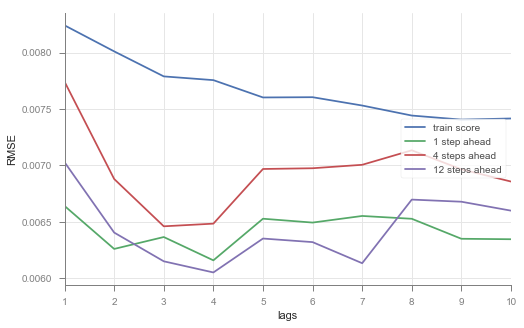

In [90]:
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('lags')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

plt.savefig('../../latex/plots/GDP_FAVAR_lags.eps', format='eps', dpi=200)

In [91]:
import FAVAR
reload(FAVAR)
FAVAR = 1
from FAVAR import FAVAR

import Model
reload(Model)
Model = 1
from Model import Model


favar = FAVAR(factors_q)
cols = ['GDP']
y_col = ['GDP']


X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)


lags = 4


# def gen_x(X, start):
#     X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
#     return X

# def gen_y(y, start):
#     y = VAR.gen_y(y, lags, start)
#     return y

# model = VAR()

# m = Model(model, transfs, gen_x, gen_y, RMSE)

# # # score, predictions, test_errors, train_scores = m.expanding_window(X_test, y_test, TEST_OFFSET)
# # # preds['FAVAR'] = predictions
# # # score, train_scores[-1]

# window = [1, 4, 12]
# ret_FAVAR = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
# results['FAVAR'] = ret_FAVAR
# # score, predictions, test_errors, train_scores = ret[1]
# [ret_FAVAR[h][0] for h in window]


def tune(p):
    X_train, y_train = df_train[cols], df_train[y_col]
    X_test, y_test = df_test[cols], df_test[y_col]


    n_factors = 1
    X_train = favar.addFactors(X_train, p)
    X_test = favar.addFactors(X_test, p)


    lags = 4

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = VAR()

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
    print(p)
    return p, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res = [tune(p) for p in range(1, 5)]

step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
1
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
2
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
3
step: 150
step: 155
step: 160
step: 165
step: 170
step: 175
step: 180
4


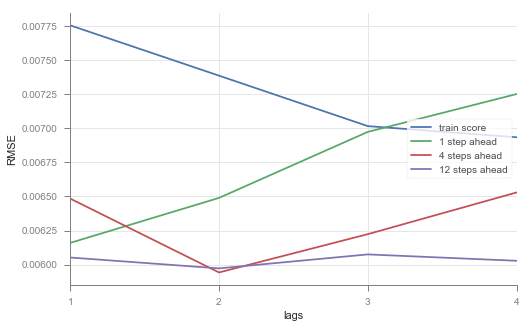

In [92]:
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('lags')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

plt.savefig('../../latex/plots/GDP_FAVAR_factors.eps', format='eps', dpi=200)

# SplitVAR (FAVAR)

In [1806]:
import splitVAR
reload(splitVAR)
splitVAR = 1
from splitVAR import splitVAR as splitVAR

import Model
reload(Model)
Model = 1
from Model import Model as Model


cols = ['GDP', 'CPI']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)


lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = model = splitVAR(5, clustering_type='GMM', proba = True, WLS=True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_SPLIT_FAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['SPLITFAVAR'] = ret_SPLIT_FAVAR
[ret_SPLIT_FAVAR[h][0] for h in window]
# score, predictions, test_errors, train_scores = m.expanding_window(X_test, y_test, TEST_OFFSET)
# preds['SPLITVAR-AR'] = predictions
# score, train_scores[-1]

step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220


[0.0069981444700701482, 0.0073336531041602246, 0.0076877331504956901]

In [1781]:
print([ret_SPLIT_FAVAR[h][0] for h in window])
[results['ARMA'][h][0] for h in window]


[0.0064900522668305365, 0.0072235737336604072, 0.0077667368086961116]


[0.0066478838056817022, 0.0077841448274712762, 0.0080527523401103026]

## MSREG (FAVAR)

In [ ]:
cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = favar.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = favar.gen_y(y, lags, start)
    return y

model = MSReg(2)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret = m.expanding_window(X_test, y_test, TRAIN_OFFSET, window, 'dynamic')
[ret[h][0] for h in window]

In [66]:
import MSReg
reload(MSReg)
MSReg = 1
from MSReg import MSReg

import Model
reload(Model)
Model = 1
from Model import Model

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MSFAVAR = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
results['MSFAVAR'] = ret_MSFAVAR
[ret_MSFAVAR[h][0] for h in window]

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:391: RuntimeWarning: invalid value encountered in true_divide
  predicted_joint_probabilities[..., t+1])


step: 150
step: 155
step: 160
step: 165


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 170


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 175


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 180


[0.0060368598839758156, 0.0066658315597749708, 0.0061207592225622732]

In [1800]:
[0.0061895930476473524, 0.0068701260970133972, 0.0075553948305520221]

[0.006189593047647352, 0.006870126097013397, 0.007555394830552022]

In [1281]:
import MLP
reload(MLP)
MLP = 1
from MLP import MLP

import Model
reload(Model)
Model = 1
from Model import Model

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((2,), training_epochs = 2000, beta=1e-8, debug=True)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [4, 12]
ret = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
[ret[h][0] for h in window]

1
5
6
7
8
9
Epoch: 0001 cost= 24.504627228
Epoch: 0101 cost= 11.250204563
Epoch: 0201 cost= 8.632513523
Epoch: 0301 cost= 7.083252430
Epoch: 0401 cost= 5.668555737
Epoch: 0501 cost= 4.473819971
Epoch: 0601 cost= 3.520187974
Epoch: 0701 cost= 2.731323600
Epoch: 0801 cost= 2.227601528
Epoch: 0901 cost= 1.848033071
Epoch: 1001 cost= 1.607211173
Epoch: 1101 cost= 1.418128788
Epoch: 1201 cost= 1.278810084
Epoch: 1301 cost= 1.179487169
Epoch: 1401 cost= 1.098869950
Epoch: 1501 cost= 1.053668320
Epoch: 1601 cost= 1.016136467
Epoch: 1701 cost= 0.989868790
Epoch: 1801 cost= 0.967343301
Epoch: 1901 cost= 0.957241774
Optimization Finished!
1
5
6
7
8


KeyboardInterrupt: 

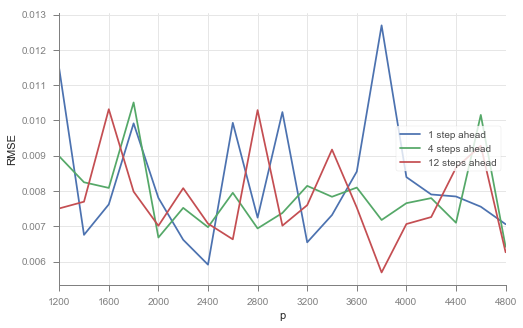

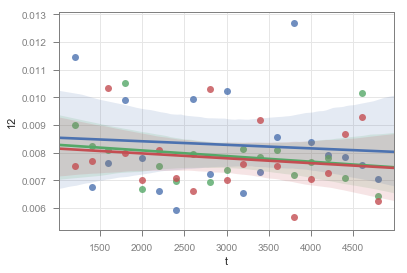

In [37]:
with open('MLP_train.p', 'rb') as f:
    res = pickle.load(f)
    
df = pd.DataFrame(res[3:])

fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()
fig2 = plt.figure()
# plt.savefig('destination_path.eps', format='eps', dpi=200)
df.columns = ['t', 'train', '1', '4', '12']
sns.regplot(x="t", y="1", data=df)
sns.regplot(x="t", y="4", data=df)
sns.regplot(x="t", y="12", data=df)

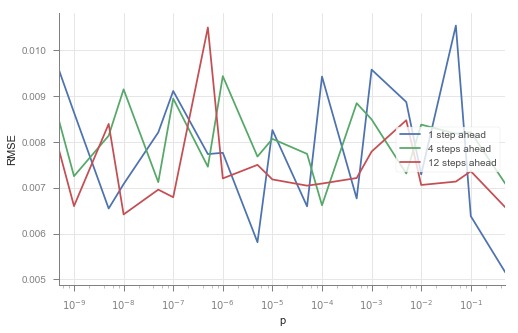

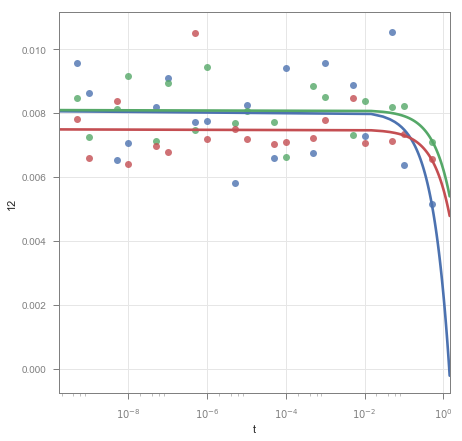

In [82]:
with open('MLP_train2.p', 'rb') as f:
    res = pickle.load(f)
    
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df[0], df[1], label='train score')
ax.semilogx(df[0], df[2], label='1 step ahead')
ax.semilogx(df[0], df[3], label='4 steps ahead')
ax.semilogx(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()
f, ax = plt.subplots(figsize=(7, 7))
# plt.savefig('destination_path.eps', format='eps', dpi=200)
df.columns = ['t', 'train', '1', '4', '12']
ax.set(xscale="log")
sns.regplot(x="t", y="1", data=df, ax=ax, ci=None)
sns.regplot(x="t", y="4", data=df, ax=ax, ci=None)
sns.regplot(x="t", y="12", data=df, ax=ax, ci=None)

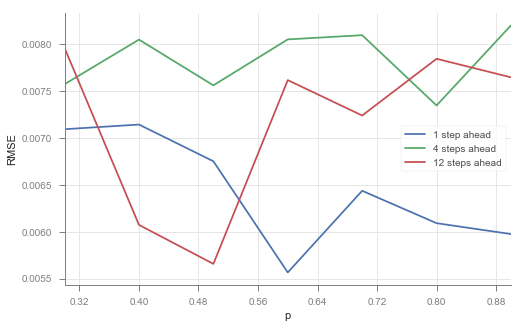

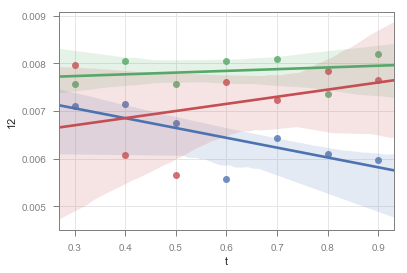

In [84]:
with open('MLP_train3.p', 'rb') as f:
    res = pickle.load(f)
    
df = pd.DataFrame(res[3:])

fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()
fig2 = plt.figure()
# plt.savefig('destination_path.eps', format='eps', dpi=200)
df.columns = ['t', 'train', '1', '4', '12']
sns.regplot(x="t", y="1", data=df)
sns.regplot(x="t", y="4", data=df)
sns.regplot(x="t", y="12", data=df)

# results

In [1810]:
def SE(pred, real):
    return (pred - real)*(pred - real)

def AE(pred, real):
    return abs(pred - real)
    
def DM(results, y, loss, cols = None):
    if cols is None:
        cols = results.keys()
    
    ret = {}
    for h in [1, 4, 12]:
        ret[h] = pd.DataFrame(columns=cols, index=cols)
        for i in cols:
            row = {}
            for j in cols:
                pred1 = results[i][h][1]
                pred2 = results[j][h][1]
                row[j] = DM_comparison(pred2, pred1, y, loss, h)
            ret[h].loc[i] = pd.Series(row)
            
            
    return ret

def DM_comparison(pred1, pred2, real, loss, h):
    first = pred1.first_valid_index()
    # remove the y values that were used for training
    real = real.loc[first:]
    
    # apply the loss function to every element 
    def f(row):
        return loss(row.iloc[0], row.iloc[1])

    loss1 = pd.concat([pred1, real], axis=1).apply(f, axis=1)
    loss2 = pd.concat([pred2, real], axis=1).apply(f, axis=1)
    d = loss1 - loss2
    d = d.reset_index(drop=True)
#     print(d)
    T = len(d)
    Z = np.mean(d) / np.sqrt(NW(d, h)/T)
#     return NW(d, h)
    return Z

def autocov(d, tau):
    T = len(d)
    mu = np.mean(d)
    return np.mean([(d[i] - mu)*(d[i-tau] - mu) for i in range(tau, T)])
    
def NW(d, h):
    q = h-1
    V = autocov(d, 0) + 2*np.sum([(1 - (nu)/(q+1)) * autocov(d, nu) for nu in range(1, q)])
    return V
    


ret = DM(results, y_test, SE)#, ['FAVAR', 'MSFAVAR', 'ARMA'])

ret[12]

,ARMA,MSAR,MSFAVAR,SPLITFAVAR,FAVAR,VAR
ARMA,NaN,0.0640412,-0.490519,-0.694025,-0.505791,0.843541
MSAR,-0.0640412,NaN,-0.550684,-0.773454,-0.575883,0.815074
MSFAVAR,0.490519,0.550684,NaN,0.261949,0.416733,1.07893
SPLITFAVAR,0.694025,0.773454,-0.261949,NaN,-0.157285,2.23791
FAVAR,0.505791,0.575883,-0.416733,0.157285,NaN,1.30697
VAR,-0.843541,-0.815074,-1.07893,-2.23791,-1.30697,NaN


In [1774]:
results['ARMA']

{1: (0.0068467016626531912,           GDP
  182  0.008234
  183  0.007942
  184  0.008026
  185  0.009414
  186  0.008524
  187  0.008077
  188  0.008177
  189  0.008476
  190  0.008374
  191  0.005897
  192  0.008024
  193  0.006409
  194  0.006889
  195  0.009322
  196  0.006914
  197  0.004249
  198  0.005574
  199  0.005208
  200 -0.001298
  201 -0.000447
  202  0.001738
  203  0.004906
  204  0.008123
  205  0.007254
  206  0.007659
  207  0.008428
  208  0.007959
  209  0.004611
  210  0.005724
  211  0.006896
  212  0.007502
  213  0.008397
  214  0.007166
  215  0.005911
  216  0.004426
  217  0.006747
  218  0.006762
  219  0.006026
  220  0.008230
  221  0.004989
  222  0.005676,           GDP
  182 -0.000857
  183 -0.000706
  184 -0.002633
  185  0.004194
  186  0.000120
  187  0.002368
  188 -0.003838
  189  0.005486
  190  0.007483
  191 -0.001931
  192  0.007405
  193 -0.001244
  194  0.000163
  195  0.005754
  196  0.013737
  197 -0.000714
  198  0.010373
  199  0.026334

In [112]:
import RF
reload(RF)
RF = 1
from RF import RF

import Model
reload(Model)
Model = 1
from Model import Model

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = RF()
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_RFFAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['RFFAVAR'] = ret_RFFAVAR
[ret_RFFAVAR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0069537129630659594, 0.0081215490550660338, 0.0084733813864399932]